# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [75]:
# откройте данные:
import pandas as pd

data = pd.read_csv("spam_or_not_spam.csv")
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [76]:
# рассчитайте частоты для классов : 
data['label'].value_counts()

0    2500
1     500
Name: label, dtype: int64

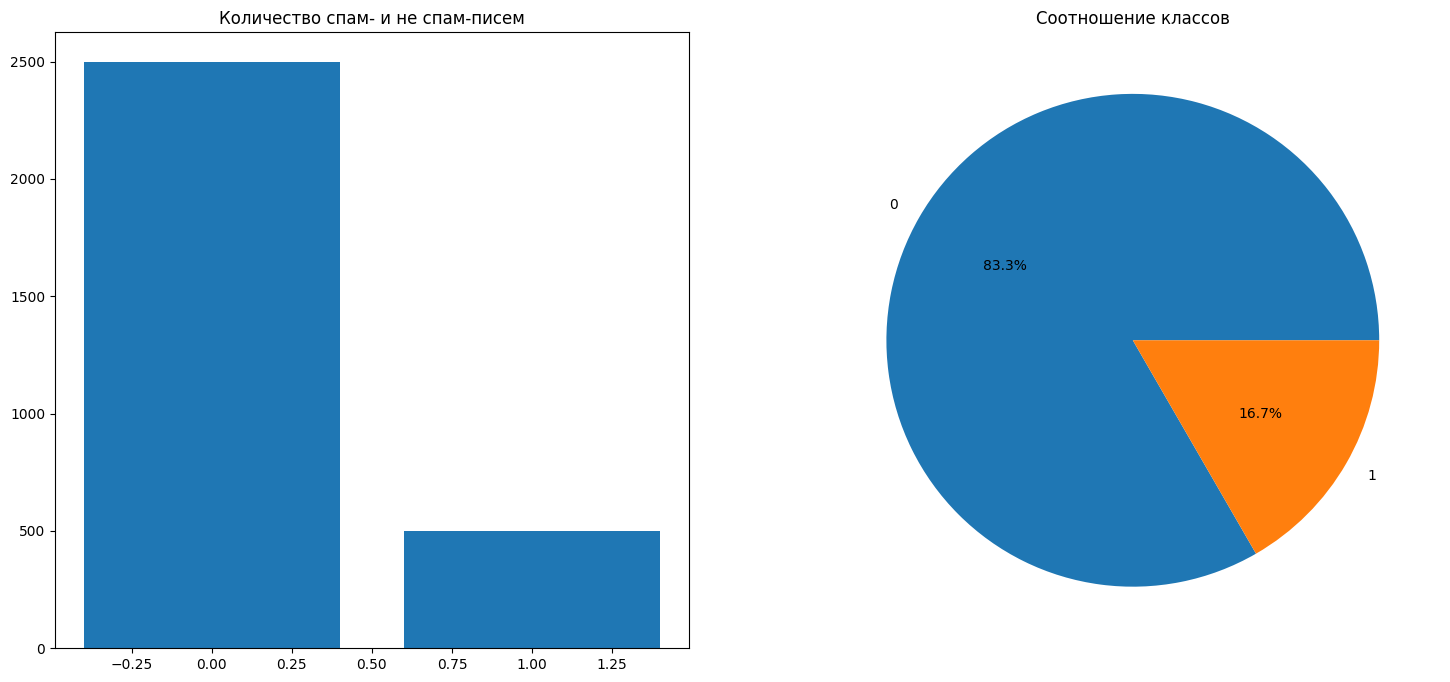

In [77]:
# визуализируйте результат: ваш код здесь
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

data_label = data['label'].value_counts()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
axes[0].bar(
    x=data_label.index,
    height = data_label
)
axes[0].set_title("Количество спам- и не спам-писем")
axes[1].pie(
    data_label,
    labels=data_label.index,
    autopct='%.1f%%'
)
axes[1].set_title("Cоотношение классов");


## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [79]:
data_clean = data.copy()
data_clean = data_clean.dropna(axis=0)
mask = data_clean['email'].str.isspace()
id = data_clean[mask]['email'].index
data_clean.iloc[id] = np.nan
data_clean = data_clean.dropna(axis=0)
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2997 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   email   2997 non-null   object 
 1   label   2997 non-null   float64
dtypes: float64(1), object(1)
memory usage: 70.2+ KB


Переводим данные в векторный вид:

In [80]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_clean["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [82]:
X.shape

(2997, 34116)

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [100]:
y = data_clean['label']

Разделите выборку на обучающую и тестовую, размер тестовой выборки возьмите как 0.25, параметр random_state определите со значением 42:

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [102]:
y_test.mean()

0.17733333333333334

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [107]:
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB(alpha=0.01)
clf.fit(X_train, y_train)

ComplementNB(alpha=0.01)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [110]:
from sklearn import metrics
y_test_predict = clf.predict(X_test)
print("accuracy: ", round(metrics.accuracy_score(y_test,y_test_predict),3))
print("precision: ", round(metrics.precision_score(y_test,y_test_predict),3))
print("recall: ", round(metrics.recall_score(y_test,y_test_predict),3)) 

accuracy:  0.991
precision:  0.977
recall:  0.97


Нарисуйте ROC-кривую:

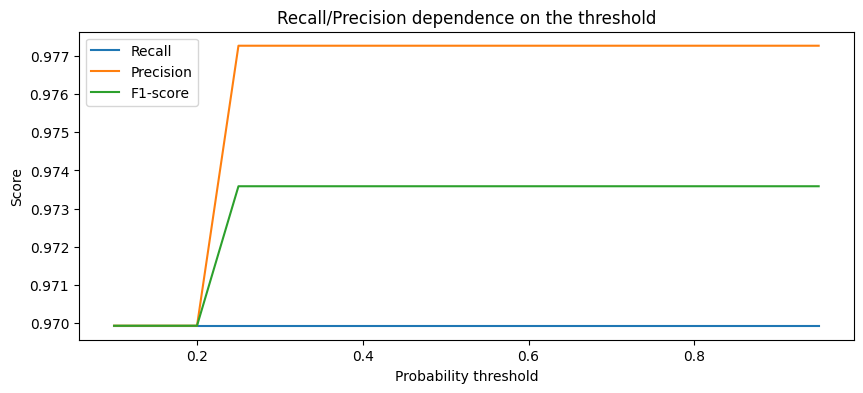

In [111]:
#Считаем вероятности 
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = clf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [117]:
from sklearn.model_selection import cross_validate, KFold
#Создаём модель
alpha = [0.001, 0.005, 0.01, 0.5, 1]
for a in alpha: 
    model = ComplementNB(alpha=a)
    #Создаём объект кросс-валидатора KFold
    kf = KFold(n_splits=5)
    
    #Считаем метрики на кросс-валидации k-fold
    cv_metrics = cross_validate(
        estimator=model, #модель
        X=X, #матрица наблюдений X
        y=y, #вектор ответов y
        cv=kf, #кросс-валидатор
        scoring='accuracy', #метрика
        return_train_score=True #подсчёт метрики на тренировочных фолдах
    )
    print("alpha= ",a)
    print(cv_metrics['test_score'])



alpha=  0.001
[0.98833333 0.99666667 0.9966611  0.97829716 0.17028381]
alpha=  0.005
[0.98166667 0.99666667 0.99499165 0.97829716 0.17028381]
alpha=  0.01
[0.98       0.99666667 0.99165275 0.97829716 0.17028381]
alpha=  0.5
[0.97666667 0.99166667 0.98497496 0.96160267 0.17028381]
alpha=  1
[0.98333333 0.99166667 0.98831386 0.96828047 0.17028381]


_Качество классификации от значения альфа не зависит._